In [82]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split, GridSearchCV
import numpy as np
from matplotlib import pyplot
import time
import pandas as pd
from geopy.geocoders import Nominatim
import math


In [356]:
general_start = time.time()

tweets = pd.read_csv("data/train_pre_processing.csv")

# Pruebas solo con variables numéricas y booleanas

In [357]:
x_features, target = tweets.select_dtypes(include=['float64','int64','bool']).iloc[:,:-1],tweets.iloc[:,-1]

In [358]:
x_train, x_test, y_train, y_test = train_test_split(x_features, target, test_size=0.2, random_state=123)

# Pruebas con valores por default del RandomForestClassifier

In [359]:
start = time.time()

rf_model = RandomForestClassifier(random_state=1)
cv = RepeatedStratifiedKFold(n_splits=10,random_state=1)

n_scores = cross_val_score(rf_model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
end = time.time()

print('ACC: %.3f (desv:  %.3f). Time: %.2f' % (np.mean(n_scores), np.std(n_scores),(end - start)/60))


ACC: 0.697 (desv:  0.017). Time: 0.56


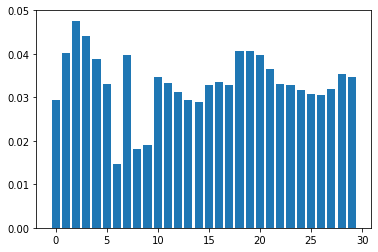

In [360]:
model = ExtraTreesClassifier()
model.fit(x_train, y_train)
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

# Pruebas descartando una columna (todas las combinaciones)

In [7]:
x_train_columns = {}

for x in range(0,30):
    column_list = []
    for y in range(0,30):
        if y != x:
            column_list.append(y)
    x_train_columns[x] = column_list

def get_dic_acc():
    results = {}
    results['accuracy'] = []
    results['std'] = []
    results['time'] = []
    
    return results
    


In [8]:
no_column = get_dic_acc()
index_no_column = []


for x in range(0,30):
    start = time.time()

    rf_model = RandomForestClassifier(random_state=1)
    cv = RepeatedStratifiedKFold(n_splits=10,random_state=1)
    x_train_2 = x_train.iloc[:,x_train_columns[x]]
    n_scores = cross_val_score(rf_model, x_train_2, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    end = time.time()
    index_no_column.append(x_train.columns[x])
    no_column['accuracy'].append(np.mean(n_scores))
    no_column['std'].append(np.std(n_scores))
    no_column['time'].append((end - start)/60)

pd.DataFrame(no_column, index=index_no_column).nlargest(10,'accuracy')     


,accuracy,std,time
total_8_ormore_words,0.697652,0.015400,0.562029
total_7_words,0.697209,0.015282,0.579899
total_words,0.697094,0.016216,0.613315
total_6_words,0.697011,0.017499,0.579460
contain_hashtag,0.696897,0.016805,0.578906
total_8_orless_words,0.696683,0.017403,0.552535
subjectivity_text,0.696683,0.016555,0.547911
total_common_chars,0.696437,0.015980,0.569281
total_7_ormore_words,0.696437,0.017007,0.545992
total_special_chars,0.696371,0.015623,0.566471


realizo una prueba eliminando aquellas columnas que no disminuyeron el resultado de Accuracy con tres decimales 

In [9]:
x_train_2 = x_train.drop(columns=['total_words','total_6_words','total_7_words','total_8_ormore_words']) 

start = time.time()

rf_model = RandomForestClassifier(random_state=1)
cv = RepeatedStratifiedKFold(n_splits=10,random_state=1)

n_scores = cross_val_score(rf_model, x_train_2, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
end = time.time()

print('ACC: %.3f (desv:  %.3f). Time: %.2f' % (np.mean(n_scores), np.std(n_scores),(end - start)/60))


ACC: 0.694 (desv:  0.016). Time: 0.56


# Pruebas variando el porcentaje de datos en  cada árbol

In [11]:
max_samples_best = 0 
max_samples_acc = 0 
max_samples_std = 0

max_samples_dic = get_dic_acc()
index_max_samples = []

max_sample = 0.1
for x in range(1,10):
    start = time.time()
    rf_model = RandomForestClassifier(random_state=1,max_samples = max_sample)
    cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)
    
    n_scores = cross_val_score(rf_model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    mean = np.mean(n_scores)
    std = np.std(n_scores)
    end = time.time()
    
    index_max_samples.append(max_sample)
    max_samples_dic['accuracy'].append(mean)
    max_samples_dic['std'].append(np.std(std))
    max_samples_dic['time'].append((end - start)/60)
                                
    if (mean > max_samples_acc) or (mean == max_samples_acc and std < max_samples_std): 
        max_samples_best = max_sample
        max_samples_acc = mean
        max_samples_std = std
    
    
    max_sample = max_sample + 0.1
    
print("Best max_sample: %.1f" % (max_samples_best))

pd.DataFrame(max_samples_dic, index=index_max_samples).nlargest(10,'accuracy')     


Best max_sample: 0.3


,accuracy,std,time
0.3,0.697586,0.0,0.348019
0.5,0.697471,0.0,0.408859
0.4,0.697094,0.0,0.391647
0.9,0.696617,0.0,0.552363
0.6,0.696552,0.0,0.433003
0.7,0.696388,0.0,0.472960
0.8,0.696059,0.0,0.503763
0.2,0.695452,0.0,0.277742
0.1,0.687094,0.0,0.228563


# Pruebas variando el máximo de fatures por  cada árbol con el mejor max_samples anterior

In [12]:
max_features_best = 0
max_features_acc = 0
max_features_std = 0

max_features_dic = get_dic_acc()
index_max_features = []

for x in range(1,len(x_train.columns)+1,2):
    start = time.time()
    rf_model = RandomForestClassifier(random_state=1,max_samples = max_samples_best, max_features= x)
    cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)
    
    n_scores = cross_val_score(rf_model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    mean = np.mean(n_scores)
    std = np.std(n_scores)
    end = time.time()
    
    index_max_features.append(x)
    max_features_dic['accuracy'].append(mean)
    max_features_dic['std'].append(np.std(std))
    max_features_dic['time'].append((end - start)/60)

    
    if (mean > max_features_acc) or (mean == max_features_acc and std < max_features_std): 
        max_features_best = x
        max_features_acc = mean
        max_features_std = std
    
print("Best max_features: %d" % (max_features_best))

pd.DataFrame(max_features_dic, index=index_max_features).nlargest(10,'accuracy')     



Best max_features: 25


,accuracy,std,time
25,0.699163,0.0,0.781295
23,0.698046,0.0,0.718575
11,0.698046,0.0,0.443558
29,0.697931,0.0,0.872447
17,0.697833,0.0,0.586303
5,0.697586,0.0,0.298593
1,0.697570,0.0,0.211231
19,0.697553,0.0,0.636940
27,0.697521,0.0,0.823266
21,0.696897,0.0,0.687050


# Pruebas variando cantidad de árboles con los mejores parámetros anteriores

In [13]:
n_estimators_best = 0
n_estimators_acc = 0
n_estimators_std = 0

n_estimators_dic = get_dic_acc()
index_n_estimators = []

for x in range(200,1001,100):
    start = time.time()
    rf_model = RandomForestClassifier(random_state=1,max_samples = max_samples_best, max_features= max_features_best, n_estimators = x)
    cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)

    n_scores = cross_val_score(rf_model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    mean = np.mean(n_scores)
    std = np.std(n_scores)
    end = time.time()

    index_n_estimators.append(x)
    n_estimators_dic['accuracy'].append(mean)
    n_estimators_dic['std'].append(np.std(std))
    n_estimators_dic['time'].append((end - start)/60)
    
    if (mean > n_estimators_acc) or (mean == n_estimators_acc and std < n_estimators_std): 
        n_estimators_best = x
        n_estimators_acc = mean
        n_estimators_std = std
 
    
print("Best n_estimators: %d" % (n_estimators_best))

pd.DataFrame(n_estimators_dic, index=index_n_estimators).nlargest(10,'accuracy')     


Best n_estimators: 600


,accuracy,std,time
600,0.702036,0.0,4.480722
500,0.702036,0.0,3.756460
700,0.701938,0.0,5.231072
400,0.701691,0.0,3.032511
900,0.701478,0.0,7.128717
800,0.701461,0.0,6.152803
1000,0.701297,0.0,7.485990
300,0.701051,0.0,2.396637
200,0.699852,0.0,1.514906


# Pruebas variando max_depth con los mejores parámetros anteriores

In [14]:
max_depth_best = 0
max_depth_acc = 0
max_depth_std = 0

max_depth_dic = get_dic_acc()
index_max_depth = []

for x in range(4,41,4):
    start = time.time()
    rf_model = RandomForestClassifier(random_state=1,max_samples = max_samples_best, max_features= max_features_best, n_estimators = n_estimators_best,max_depth = x)
    cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)

    n_scores = cross_val_score(rf_model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    mean = np.mean(n_scores)
    std = np.std(n_scores)
    end = time.time()

    index_max_depth.append(x)
    max_depth_dic['accuracy'].append(mean)
    max_depth_dic['std'].append(np.std(std))
    max_depth_dic['time'].append((end - start)/60)
    
    if (mean > max_depth_acc) or (mean == max_depth_acc and std < max_depth_std): 
        max_depth_best = x
        max_depth_acc = mean
        max_depth_std = std
    
print("Best max_depth: %d" % (max_depth_best))

pd.DataFrame(max_depth_dic, index=index_max_depth).nlargest(10,'accuracy') 
                                


Best max_depth: 36


,accuracy,std,time
32,0.702036,0.0,4.492241
36,0.702036,0.0,4.491540
40,0.702036,0.0,4.478079
28,0.701839,0.0,4.525470
24,0.701544,0.0,4.748599
20,0.701412,0.0,4.496911
16,0.701248,0.0,4.388133
12,0.699409,0.0,4.007713
8,0.690969,0.0,3.195085
4,0.677964,0.0,1.875824


# Pruebas variando min_samples_split con lo mejores parámetros anteriores

In [15]:
min_samples_split_best = 0
min_samples_split_acc = 0
min_samples_split_std = 0

min_samples_split_dic = get_dic_acc()
index_min_samples_split = []

for x in range(4,41,4):
    start = time.time()
    rf_model = RandomForestClassifier(random_state=1,max_samples = max_samples_best, max_features= max_features_best, n_estimators = n_estimators_best,max_depth = max_depth_best,min_samples_split = x)
    cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)

    n_scores = cross_val_score(rf_model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    mean = np.mean(n_scores)
    std = np.std(n_scores)
    end = time.time()

    index_min_samples_split.append(x)
    min_samples_split_dic['accuracy'].append(mean)
    min_samples_split_dic['std'].append(np.std(std))
    min_samples_split_dic['time'].append((end - start)/60)
    
    if (mean > min_samples_split_acc) or (mean == min_samples_split_acc and std < min_samples_split_std): 
        min_samples_split_best = x
        min_samples_split_acc = mean
        min_samples_split_std = std
    
print("Best min_samples_split: %d" % (min_samples_split_best))

pd.DataFrame(min_samples_split_dic, index=index_min_samples_split).nlargest(10,'accuracy') 



Best min_samples_split: 4


,accuracy,std,time
4,0.700805,0.0,4.475531
8,0.699951,0.0,4.294994
12,0.697619,0.0,4.147077
16,0.697438,0.0,4.029104
20,0.695895,0.0,3.923967
24,0.695107,0.0,3.837195
28,0.694417,0.0,3.691405
32,0.692939,0.0,3.611527
36,0.692775,0.0,3.512474
40,0.691970,0.0,3.419798


# Pruebas variando min_samples_leaf con los mejores parametros anteriores

In [16]:
min_samples_leaf_best = 0
min_samples_leaf_acc = 0
min_samples_leaf_std = 0

min_samples_leaf_dic = get_dic_acc()
index_min_samples_leaf = []

for x in range(1,21,2):
    start = time.time()
    rf_model = RandomForestClassifier(random_state=1,max_samples = max_samples_best, max_features= max_features_best, n_estimators = n_estimators_best,max_depth = max_depth_best,min_samples_split = min_samples_split_best,min_samples_leaf = x)
    cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)

    n_scores = cross_val_score(rf_model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    mean = np.mean(n_scores)
    std = np.std(n_scores)
    end = time.time()

    index_min_samples_leaf.append(x)
    min_samples_leaf_dic['accuracy'].append(mean)
    min_samples_leaf_dic['std'].append(np.std(std))
    min_samples_leaf_dic['time'].append((end - start)/60)
                                        
    if (mean > min_samples_leaf_acc) or (mean == min_samples_leaf_acc and std < min_samples_leaf_std): 
        min_samples_leaf_best = x
        min_samples_leaf_acc = mean
        min_samples_leaf_std = std
    
print("Best min_samples_leaf: %d" % (min_samples_leaf_best))

pd.DataFrame(min_samples_leaf_dic, index=index_min_samples_leaf).nlargest(10,'accuracy') 



Best min_samples_leaf: 1


,accuracy,std,time
1,0.700805,0.0,4.759413
3,0.698292,0.0,4.008171
5,0.695304,0.0,3.824755
7,0.693530,0.0,3.454393
9,0.692069,0.0,3.286654
11,0.690805,0.0,3.134810
13,0.690755,0.0,3.040525
15,0.689491,0.0,2.925283
17,0.688966,0.0,2.824614
19,0.688210,0.0,2.753830


# Pruebas variando max_leaf_nodes con los mejores parametros anteriores

In [17]:
max_leaf_nodes_best = 0
max_leaf_nodes_acc = 0
max_leaf_nodes_std = 0

max_leaf_nodes_dic = get_dic_acc()
index_max_leaf_nodes = []

for x in range(2,2001,200):
    start = time.time()
    rf_model = RandomForestClassifier(random_state=1,max_samples = max_samples_best, max_features= max_features_best, n_estimators = n_estimators_best,max_depth = max_depth_best,min_samples_split = min_samples_split_best,min_samples_leaf = min_samples_leaf_best, max_leaf_nodes = x)
    cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)

    n_scores = cross_val_score(rf_model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    mean = np.mean(n_scores)
    std = np.std(n_scores)
    end = time.time()

    index_max_leaf_nodes.append(x)
    max_leaf_nodes_dic['accuracy'].append(mean)
    max_leaf_nodes_dic['std'].append(np.std(std))
    max_leaf_nodes_dic['time'].append((end - start)/60)
                                        
    if (mean > max_leaf_nodes_acc) or (mean == max_leaf_nodes_acc and std < max_leaf_nodes_std): 
        max_leaf_nodes_best = x
        max_leaf_nodes_acc = mean
        max_leaf_nodes_std = std
    
print("Best max_leaf_nodes: %d" % (max_leaf_nodes_best))

pd.DataFrame(max_leaf_nodes_dic, index=index_max_leaf_nodes).nlargest(10,'accuracy') 



Best max_leaf_nodes: 402


,accuracy,std,time
402,0.701002,0.0,4.865907
602,0.701002,0.0,4.658613
802,0.701002,0.0,4.600789
1002,0.701002,0.0,4.526143
1202,0.701002,0.0,4.661767
1402,0.701002,0.0,4.600308
1602,0.701002,0.0,4.560187
1802,0.701002,0.0,4.530217
202,0.699622,0.0,4.175181
2,0.641954,0.0,1.275443


# Grid searh usando valores cercanos a los mejores parámetros encontrados anteriormente 

In [22]:
rf_model = RandomForestClassifier(random_state = 1)

n_estimators = [200,400]
max_features = [5, 25]
criterion = ['gini','entropy']
max_depth = [16,24,36]
min_samples_split = [4,8,12]
min_samples_leaf = [1,7,17]
max_leaf_nodes = [2,200,400]
max_samples = [max_samples_best]

grid = {'criterion' : criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': max_leaf_nodes,'max_samples': max_samples}
start = time.time()
grid_serch_CV = GridSearchCV(estimator = rf_model, param_grid = grid, cv = 10, n_jobs = 2, scoring = 'accuracy')
grid_serch_CV.fit(x_train, y_train)
end = time.time()


In [23]:
pd.DataFrame(grid_serch_CV.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_max_leaf_nodes,param_max_samples,param_min_samples_leaf,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.353912,0.028394,0.018444,0.000809,gini,16,5,2,0.3,1,...,0.607553,0.586207,0.607553,0.660099,0.628900,0.628900,0.638752,0.626273,0.020113,568
1,0.706413,0.020915,0.037586,0.004882,gini,16,5,2,0.3,1,...,0.607553,0.591133,0.612479,0.658456,0.632184,0.632184,0.637110,0.625944,0.017437,622
2,0.369416,0.028920,0.020718,0.005400,gini,16,5,2,0.3,1,...,0.607553,0.586207,0.607553,0.660099,0.628900,0.628900,0.638752,0.626273,0.020113,568
3,0.820393,0.113239,0.046681,0.009755,gini,16,5,2,0.3,1,...,0.607553,0.591133,0.612479,0.658456,0.632184,0.632184,0.637110,0.625944,0.017437,622
4,0.405841,0.060110,0.023069,0.004528,gini,16,5,2,0.3,1,...,0.607553,0.586207,0.607553,0.660099,0.628900,0.628900,0.638752,0.626273,0.020113,568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,3.087910,0.123530,0.054823,0.008297,entropy,36,25,400,0.3,17,...,0.696223,0.673235,0.688013,0.709360,0.701149,0.704433,0.701149,0.691790,0.014779,259
644,1.475321,0.015341,0.025667,0.000615,entropy,36,25,400,0.3,17,...,0.697865,0.656814,0.681445,0.701149,0.706076,0.704433,0.692939,0.689491,0.015516,325
645,2.995616,0.120979,0.050206,0.001170,entropy,36,25,400,0.3,17,...,0.696223,0.673235,0.688013,0.709360,0.701149,0.704433,0.701149,0.691790,0.014779,259
646,1.508802,0.042571,0.027955,0.001991,entropy,36,25,400,0.3,17,...,0.697865,0.656814,0.681445,0.701149,0.706076,0.704433,0.692939,0.689491,0.015516,325


# Generación de features a partir del uso de CV mean encoding sobre keyword_grouped, city and country

In [24]:
geolocator = Nominatim(user_agent="orga_datos")
def getGeoData(x):
    if pd.isna(x):
        return pd.NA
    try:
        l = geolocator.geocode(x, timeout=20)
    except:
        return pd.NA
    
    if l == None:
        return pd.NA
    return (l.address, l.latitude, l.longitude)

address = tweets.location.transform(lambda x: getGeoData(x))

In [181]:
def get_column_with_cv_mean_encoding(column_name):
    data = x_train.join(y_train)
    total_true = data.groupby(column_name).target.transform(sum).fillna(0)
    dic_total = data.groupby(column_name)[column_name].count().to_dict()
    total = data[column_name].transform(lambda x: dic_total[x])
    total = total.transform(lambda x: x + 1 if x == 1 else x)
    
    return (total_true - data.target) / (total - 1)



In [273]:
x_train['latitud'] = address.transform(lambda x: 0 if pd.isna(x) else x[1]).astype('float64')
x_train['longitud'] = address.transform(lambda x:  0 if pd.isna(x) else x[2]).astype('float64')

x_train['country'] = address.transform(lambda x: 'unknown' if pd.isna(x) else x[0].split(",")[len(x[0].split(","))-1])
x_train['city'] = address.transform(lambda x: 'unknown' if pd.isna(x) else ('unknown' if len(x[0].split(",")) < 2 else x[0].split(",")[len(x[0].split(","))-2]))
x_train['keyword_grouped'] = tweets['keyword_grouped'].fillna('unknown')

x_train['country_cv_mean'] = get_column_with_cv_mean_encoding('country')
x_train['city_cv_mean'] = get_column_with_cv_mean_encoding('city')
x_train['keyword_cv_mean'] = get_column_with_cv_mean_encoding('keyword_grouped')

country_cv_mean_dict = x_train.groupby('country').country_cv_mean.mean().to_dict()
city_cv_mean_dict = x_train.groupby('city').city_cv_mean.mean().to_dict()
keyword_cv_mean_dict = x_train.groupby('keyword_grouped').keyword_cv_mean.mean().to_dict()



/Users/jtorresbaiva/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/jtorresbaiva/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jtorresbaiva/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [274]:
x_train = x_train.select_dtypes(include=['float64','int64','bool'])

In [275]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6090 entries, 6445 to 3582
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_words           6090 non-null   int64  
 1   len_text              6090 non-null   int64  
 2   total_upper_chars     6090 non-null   int64  
 3   total_numbers_chars   6090 non-null   int64  
 4   total_special_chars   6090 non-null   int64  
 5   total_common_chars    6090 non-null   int64  
 6   contain_question      6090 non-null   bool   
 7   contain_link          6090 non-null   bool   
 8   contain_hashtag       6090 non-null   bool   
 9   contain_upper_words   6090 non-null   bool   
 10  total_3_words         6090 non-null   int64  
 11  total_4_words         6090 non-null   int64  
 12  total_5_words         6090 non-null   int64  
 13  total_6_words         6090 non-null   int64  
 14  total_7_words         6090 non-null   int64  
 15  total_8_words     

### Pruebas incluyendo nuevos features con hiperparámetros por default 

In [276]:
start = time.time()

rf_model = RandomForestClassifier(random_state=1)
cv = RepeatedStratifiedKFold(n_splits=10,random_state=1)

n_scores = cross_val_score(rf_model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
end = time.time()

print('ACC: %.3f (desv:  %.3f). Time: %.2f' % (np.mean(n_scores), np.std(n_scores),(end - start)/60))

ACC: 0.942 (desv:  0.010). Time: 0.70


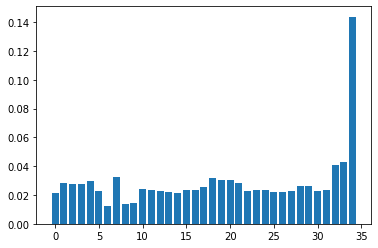

In [277]:
model = ExtraTreesClassifier()
model.fit(x_train, y_train)
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

In [327]:
x_test['latitud'] = address.transform(lambda x: 0 if pd.isna(x) else x[1]).astype('float64')
x_test['longitud'] = address.transform(lambda x:  0 if pd.isna(x) else x[2]).astype('float64')

x_test['country'] = address.transform(lambda x: 'unknown' if pd.isna(x) else x[0].split(",")[len(x[0].split(","))-1])
x_test['city'] = address.transform(lambda x: 'unknown' if pd.isna(x) else ('unknown' if len(x[0].split(",")) < 2 else x[0].split(",")[len(x[0].split(","))-2]))
x_test['keyword_grouped'] = tweets['keyword_grouped'].fillna('unknown')

x_test['country_cv_mean'] = x_test.country.transform(lambda x: country_cv_mean_dict[x] if x in country_cv_mean_dict else country_cv_mean_dict['unknown'])
x_test['city_cv_mean'] = x_test.city.transform(lambda x: city_cv_mean_dict[x] if x in city_cv_mean_dict else city_cv_mean_dict['unknown'])
x_test['keyword_cv_mean'] = x_test.keyword_grouped.transform(lambda x: keyword_cv_mean_dict[x] if x in keyword_cv_mean_dict else keyword_cv_mean_dict['unknown'])
 


In [330]:
x_test = x_test.select_dtypes(include=['float64','int64','bool'])
rf_model = RandomForestClassifier(random_state=1)
rf_model.fit(x_train, y_train)
preds = rf_model.predict(x_test)
acc = accuracy_score(preds,y_test)
print("ACC: %f" % (acc))

ACC: 0.613263


Sacando los features derivados de location se obtiene:

In [331]:
rf_model = RandomForestClassifier(random_state=1)
rf_model.fit(x_train.drop(columns=['city_cv_mean','country_cv_mean','longitud','latitud']), y_train)
preds = rf_model.predict(x_test.drop(columns=['city_cv_mean','country_cv_mean','longitud','latitud']))
acc = accuracy_score(preds,y_test)
print("ACC: %f" % (acc))

ACC: 0.757058


# Pruebas con diferentes hiperparámetros (usando los mejores anteriores)

In [226]:
rf_model = RandomForestClassifier(random_state = 1)

n_estimators = [200,400,600]
max_features = [5, 11]
criterion = ['gini']
max_depth = [32,36]
min_samples_split = [4,8,12]
min_samples_leaf = [1,7,17]
max_leaf_nodes = [2,200,400]
max_samples = [0.3]

grid = {'criterion' : criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': max_leaf_nodes,'max_samples': max_samples}
start = time.time()
grid_serch_CV2 = GridSearchCV(estimator = rf_model, param_grid = grid, cv = 10, n_jobs = 2, scoring = 'accuracy')
grid_serch_CV2.fit(x_train, y_train)
end = time.time()
print((end-start)/60)

34.50698081652323


In [306]:
pd.DataFrame(grid_serch_CV2.cv_results_).nlargest(10,'mean_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_max_leaf_nodes,param_max_samples,param_min_samples_leaf,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
110,2.658391,0.052303,0.074127,0.001517,gini,32,11,200,0.3,1,...,0.962233,0.952381,0.962233,0.960591,0.957307,0.952381,0.954023,0.959934,0.005406,1
137,2.542163,0.019573,0.071041,0.002333,gini,32,11,400,0.3,1,...,0.962233,0.952381,0.962233,0.960591,0.957307,0.952381,0.954023,0.959934,0.005406,1
272,2.635924,0.131114,0.077735,0.009834,gini,36,11,200,0.3,1,...,0.962233,0.952381,0.962233,0.960591,0.957307,0.952381,0.954023,0.959934,0.005406,1
299,2.520499,0.021186,0.069673,0.001561,gini,36,11,400,0.3,1,...,0.962233,0.952381,0.962233,0.960591,0.957307,0.952381,0.954023,0.959934,0.005406,1
109,1.776867,0.045597,0.052248,0.005160,gini,32,11,200,0.3,1,...,0.962233,0.952381,0.962233,0.958949,0.955665,0.950739,0.954023,0.959606,0.006020,5
113,2.553020,0.109552,0.073353,0.008426,gini,32,11,200,0.3,1,...,0.962233,0.954023,0.957307,0.957307,0.957307,0.952381,0.955665,0.959606,0.005406,5
136,1.696598,0.023743,0.050206,0.004926,gini,32,11,400,0.3,1,...,0.962233,0.952381,0.962233,0.958949,0.955665,0.950739,0.954023,0.959606,0.006020,5
140,2.496653,0.020352,0.070859,0.002684,gini,32,11,400,0.3,1,...,0.962233,0.954023,0.957307,0.957307,0.957307,0.952381,0.955665,0.959606,0.005406,5
271,1.702146,0.024227,0.052475,0.008614,gini,36,11,200,0.3,1,...,0.962233,0.952381,0.962233,0.958949,0.955665,0.950739,0.954023,0.959606,0.006020,5
275,2.526568,0.071233,0.074470,0.005204,gini,36,11,200,0.3,1,...,0.962233,0.954023,0.957307,0.957307,0.957307,0.952381,0.955665,0.959606,0.005406,5


In [370]:
x_train.iloc[:,[0,2]].columns.tolist()

['total_words', 'total_upper_chars']

In [389]:
lis = [1,2,[],[]]

In [390]:
lis.remove([])

In [391]:
lis

[1, 2, []]